# <font color='blue'>Análise de Preço e Análise Textual do Noticiário Econômico Para Previsão de Ativos Financeiros</font>

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import os
import re
import nltk
import xgboost
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
from pandas_datareader.data import DataReader
from datetime import datetime

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Jupyter Notebook of DRGM" --iversions

Author: Jupyter Notebook of DRGM

numpy     : 1.20.2
nltk      : 3.5
re        : 2.2.1
pandas    : 1.2.3
matplotlib: 3.4.1
xgboost   : 1.5.0
lightgbm  : 3.2.1
seaborn   : 0.11.1



## Carregando os Dados

In [3]:
# Carregando o dataset de texto de notícias
columns = ['Date', 'Category', 'News']
df_texto = pd.read_csv('dados/india-news-headlines.csv', names = columns)

In [4]:
# Shape do dataframe
df_texto.shape

(3424068, 3)

In [5]:
# Visualizando amostra do dataset
df_texto.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [6]:
# Vamos remover a primeira linha pois é o cabeçalho do arquivo
df_texto.drop(0, inplace = True)

In [7]:
# Vamos remover a coluna categoria pois não precisamos dela para nossa análise
df_texto.drop('Category', axis = 1, inplace = True)

In [8]:
# Visualizando amostra do dataset
df_texto.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


In [9]:
# Carregamos agora o dataset de cotação de ações
df_numerico = pd.read_csv('dados/BSESN.csv')

In [10]:
# Shape do dataframe
df_numerico.shape

(3682, 7)

In [11]:
# Visualizando amostra do dataset
df_numerico.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [12]:
# Visualizando amostra do dataset
df_numerico.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3677,2019-11-25,40439.660156,40931.710938,40393.898438,40889.230469,40889.230469,28600.0
3678,2019-11-26,41022.851563,41120.281250,40710.199219,40821.300781,40821.300781,32800.0
3679,2019-11-27,40979.390625,41075.761719,40848.699219,41020.609375,41020.609375,32400.0
3680,2019-11-28,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,30900.0
3681,2019-11-29,41138.261719,41143.218750,40664.179688,40793.808594,40793.808594,46700.0


## Análise Exploratória e Limpeza dos Dados

> Vamos explorar primeiro o dataset de texto

In [13]:
# Ajusta a coluna de data e visualiza info do dataset de texto
df_texto['Date'] = pd.to_datetime(df_texto['Date'], format = '%Y%m%d')
df_texto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


Vamos remover dos textos caracteres que não sejam letras.

In [14]:
# Removendo caracteres
df_texto.replace("[^a-zA-Z']", " ", regex = True, inplace = True)
df_texto['News'].head()

1    Status quo will not be disturbed at Ayodhya  s...
2                  Fissures in Hurriyat over Pak visit
3                America's unwanted heading for India 
4                   For bigwigs  it is destination Goa
5                 Extra buses to clear tourist traffic
Name: News, dtype: object

Vamos agrupar o total de manchetes de notícias para cada dia, remover duplicatas e fazer o reset do índice.

In [15]:
%%time
df_texto['News'] = df_texto.groupby(['Date']).transform(lambda x: ' '.join(x))
df_texto = df_texto.drop_duplicates()
df_texto.reset_index(inplace = True, drop = True)

Wall time: 2min 58s


In [16]:
# Visualiza uma amostra dos dados
df_texto.head()

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...


In [17]:
# Vamos checar se temos valores ausentes
df_texto.isnull().sum()

Date    0
News    0
dtype: int64

In [18]:
# Shape do dataframe
df_texto.shape

(7262, 2)

> Exploramos agora o dataset numérico

In [19]:
# Ajustamos a coluna de data
df_numerico['Date'] = pd.to_datetime(df_numerico['Date'])

In [20]:
# Visualiza uma amostra dos dados
df_numerico.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [21]:
# Info do dataset
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3682 non-null   datetime64[ns]
 1   Open       3655 non-null   float64       
 2   High       3655 non-null   float64       
 3   Low        3655 non-null   float64       
 4   Close      3655 non-null   float64       
 5   Adj Close  3655 non-null   float64       
 6   Volume     3655 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 201.5 KB


In [22]:
# Resumo estatístico
df_numerico.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3.655000e+03
mean,21146.347264,21269.132682,20984.649405,21124.125256,21124.125256,1.037558e+05
std,8749.525123,8759.377962,8716.504502,8733.757649,8733.757649,1.237143e+06
min,6093.660156,6174.000000,6069.330078,6102.740234,6102.740234,8.000000e+02
25%,15181.980469,15328.830078,15007.475098,15149.320312,15149.320312,1.060000e+04
50%,19072.019531,19201.919922,18864.810547,19016.460938,19016.460938,1.420000e+04
75%,27634.455078,27772.924805,27438.979493,27579.464844,27579.464844,2.000000e+04
max,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,3.181510e+07


In [23]:
# Checando por valores ausentes
df_numerico.isnull().sum()

Date          0
Open         27
High         27
Low          27
Close        27
Adj Close    27
Volume       27
dtype: int64

In [24]:
# Drop dos valores NA
df_numerico.dropna(inplace = True)

In [25]:
# Checando por valores ausentes
df_numerico.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [26]:
# Shape
df_numerico.shape

(3655, 7)

Text(0, 0.5, 'BSESN')

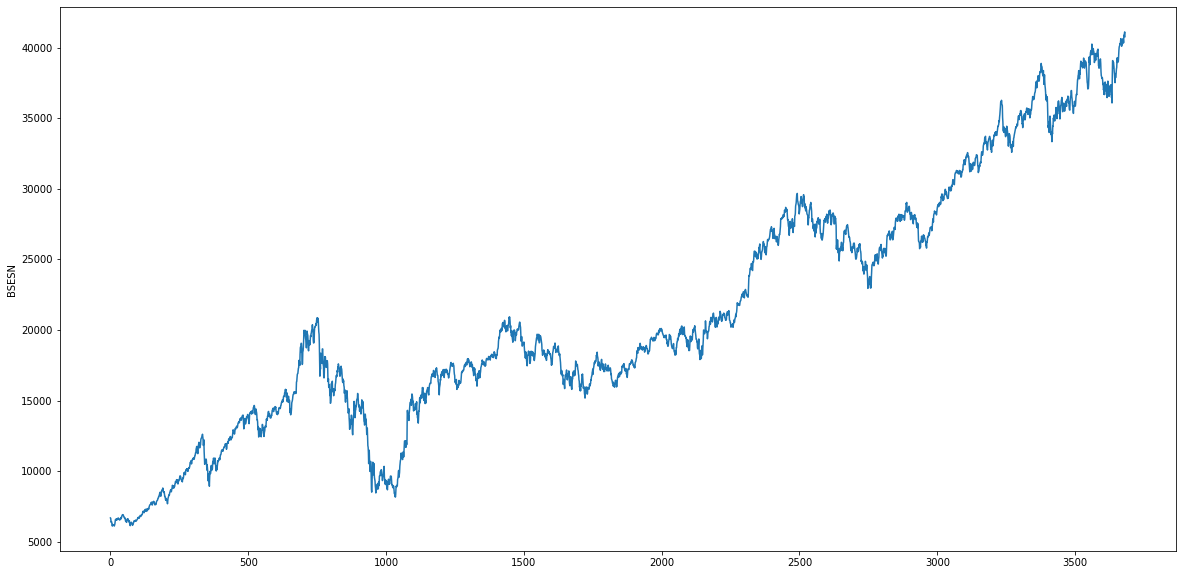

In [27]:
# Plot
plt.figure(figsize = (20, 10))
df_numerico['Close'].plot()
plt.ylabel('BSESN')

## Análise Numérica

## Plot da Média Móvel

In [28]:
# Variável que usaremos no gráfico
close = df_numerico['Close']

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [29]:
# Calcula as estatísticas móveis
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

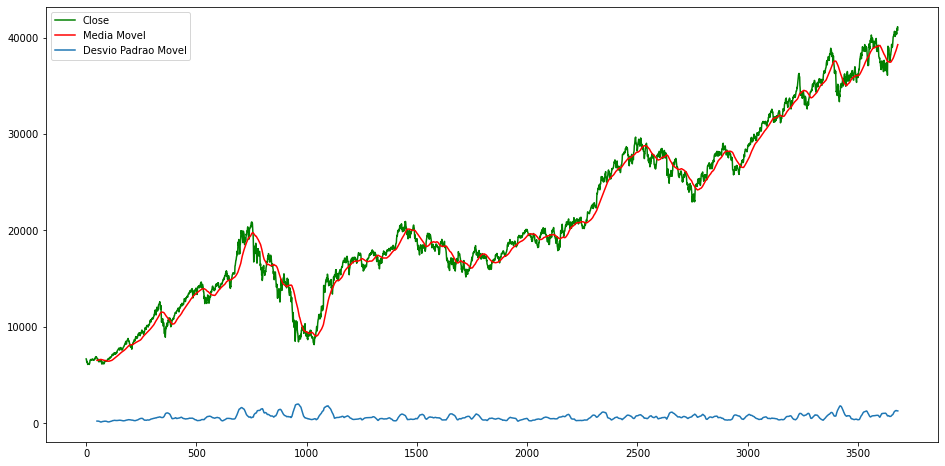

In [31]:
# Plot
plt.figure(figsize = (16, 8))
df_numerico['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Media Movel')
std.plot(label = 'Desvio Padrao Movel')
plt.legend()

## Plot dos Retornos

In [32]:
# Calcula os retornos (ganhos)
retornos = close / close.shift(1) - 1

<Figure size 432x288 with 0 Axes>

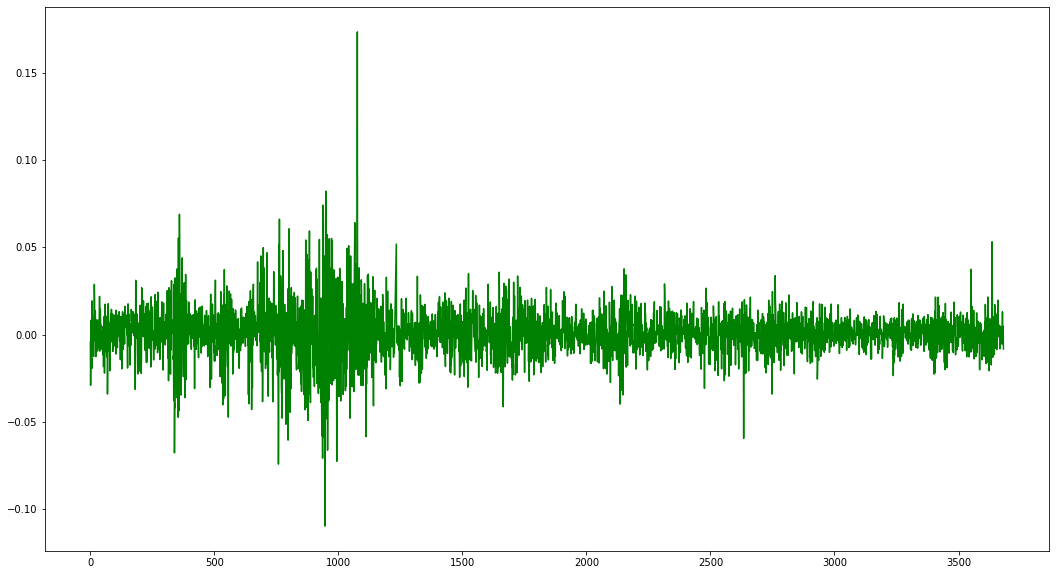

<Figure size 432x288 with 0 Axes>

In [33]:
# Plot
plt.figure(figsize = (18, 10))
retornos.plot(label = 'Retorno', color = 'g')
plt.figure('Retornos')

Vamos dividir os dados em treino e teste.

In [38]:
# Split em dados de treino e teste
dados_treino = df_numerico[:3000]
dados_teste = df_numerico[3000:]

In [39]:
# Shape df_treino
dados_treino.shape

(3000, 7)

In [40]:
# Shape df_teste
dados_teste.shape

(655, 7)

## Testando a Estacionaridade

Uma série estacionária é o que em matemática costuma se chamar série convergente, ou seja, aquela que flutua em torno de uma mesma média ao longo do tempo.

Para criar um modelo de previsão de série temporal, precisamos validar a suposição de que a série é estacionária. Vamos criar uma função e testar em nossos dados.

In [42]:
# Função para estar a eatacionaridade
def testa_estacionaridade(timeseries):
    
    # Calcula as estatísticas móveis
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    
    # Plot das estatísticas móveis
    plt.figure(figsize = (18, 9))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'r', label = 'Media Movel')
    plt.plot(rolstd, color = 'black', label = 'Devio Padrao Movel')
    plt.xlabel('Data')
    plt.legend()
    plt.title('Estatisticas Moveis', fontsize = 30)
    plt.show(block = False)
    
    print('Resultados do Teste Dickey Fuller:')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'Valor-p', 'Numero de Lags', 'Numero de Observacoes']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Evidencias fortes para rejeitar a hipotese nula (H0). Os dados sao estacionarios.')
    else:
        print('Evidencia fraca contra hipotese nula. Serie temporal nao eh estacionaria.')

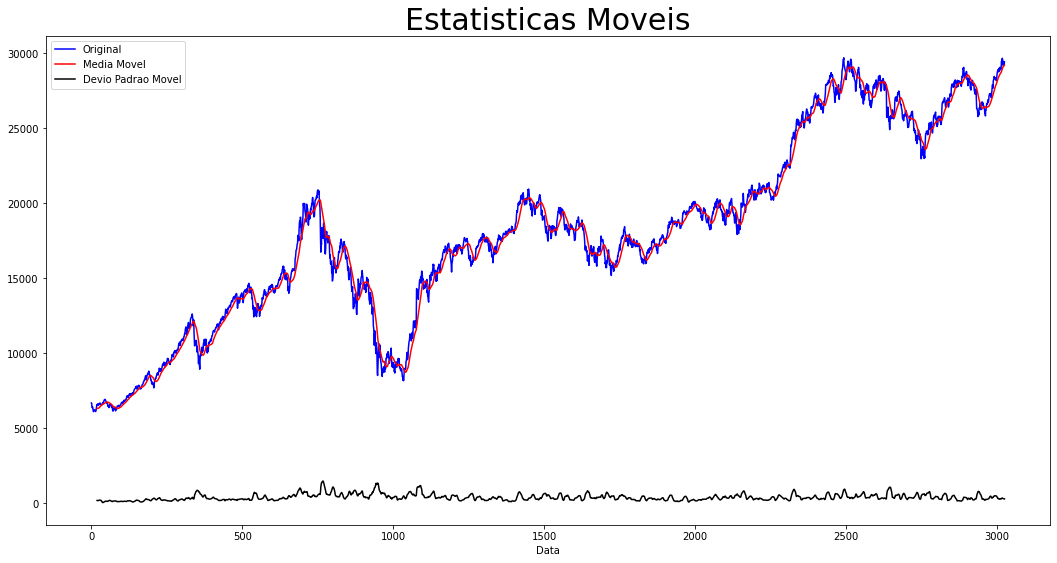

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -1.0674427255215442
Valor-p : 0.7278792554637016
Numero de Lags : 5
Numero de Observacoes : 2994
Evidencia fraca contra hipotese nula. Serie temporal nao eh estacionaria.


In [43]:
# Aplica a função
testa_estacionaridade(dados_treino['Close'])

Série temporal não é estacionária. Vamos aplicar transformação de log aos dados.

In [44]:
# Aplica transformação de log
dados_treino_log = np.log(dados_treino['Close'])
dados_teste_log = np.log(dados_teste['Close'])

In [45]:
# Média móvel
media_movel = dados_treino_log.rolling(24).mean()

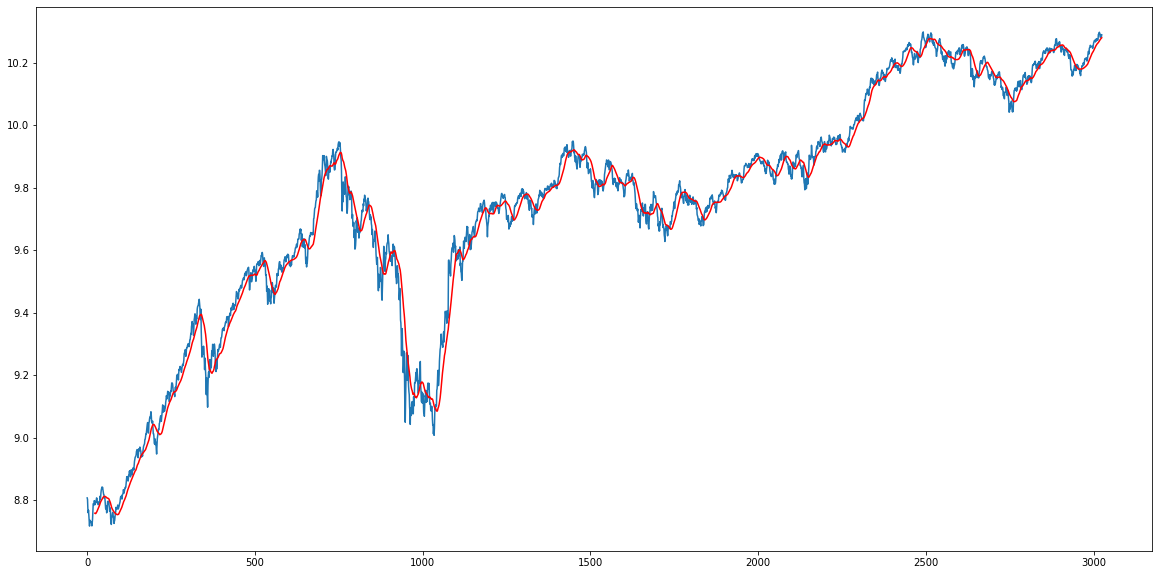

In [46]:
# Plot
plt.figure(figsize = (20, 10))
plt.plot(dados_treino_log)
plt.plot(media_movel, color = 'red')

In [47]:
# Drop de valores NA
dados_treino_log.dropna(inplace = True)
dados_teste_log.dropna(inplace = True)

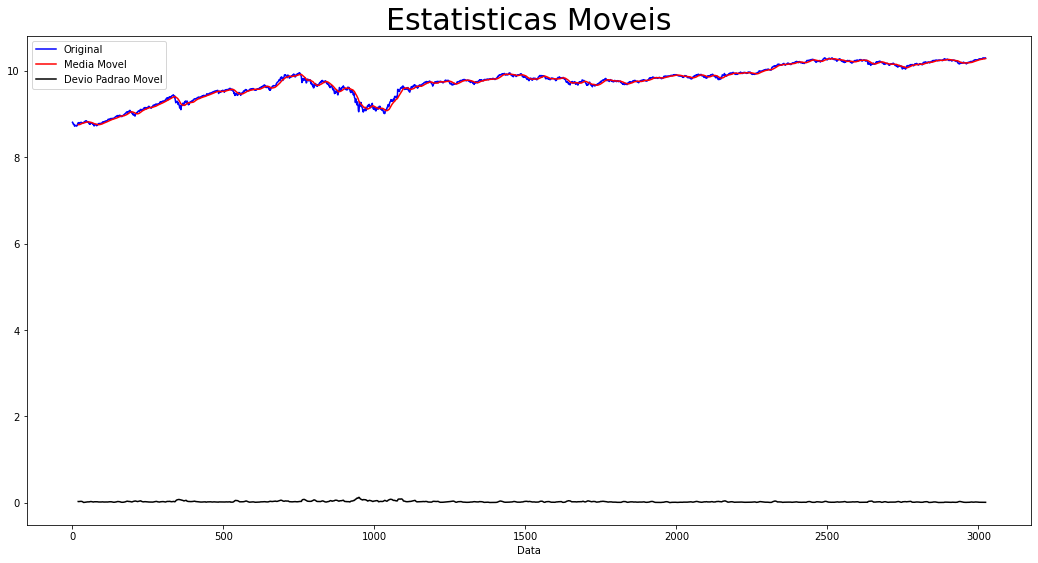

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -2.0545802810776808
Valor-p : 0.26316567390878287
Numero de Lags : 4
Numero de Observacoes : 2995
Evidencia fraca contra hipotese nula. Serie temporal nao eh estacionaria.


In [48]:
# Aplica a função
testa_estacionaridade(dados_treino_log)

Série ainda não estacionária. Vamos visualizar por outro ângulo.

In [49]:
# Calcula a diferença entre log e media_movel
dados_treino_log_diff = dados_treino_log - media_movel
dados_treino_log_diff.dropna(inplace = True)

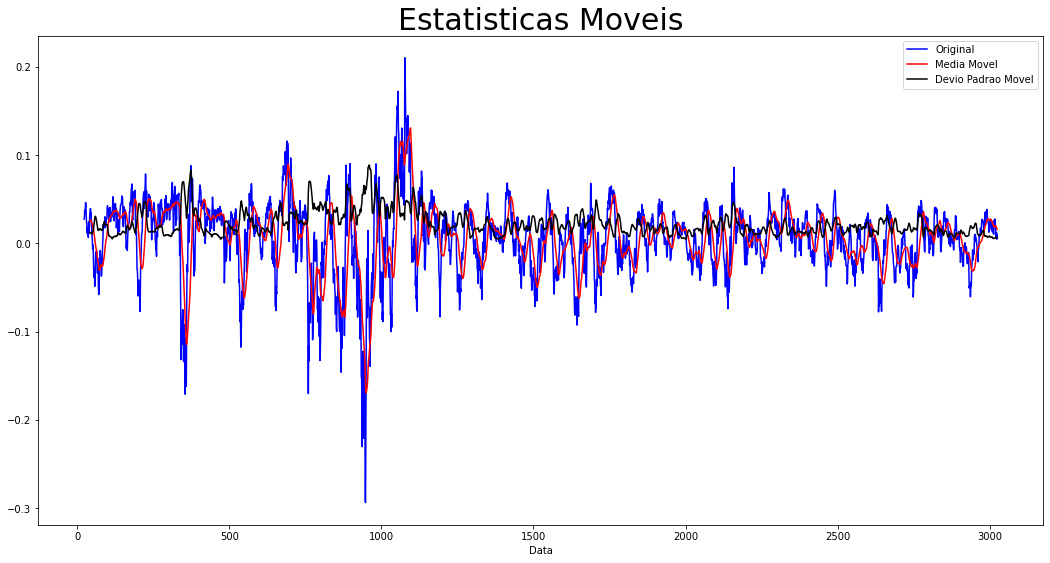

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -8.109803873988948
Valor-p : 1.2345888654260541e-12
Numero de Lags : 22
Numero de Observacoes : 2954
Evidencias fortes para rejeitar a hipotese nula (H0). Os dados sao estacionarios.


In [50]:
# Aplica a função
testa_estacionaridade(dados_treino_log_diff)

Sim, a série é estacionária. Vamos criar um modelo ARIMA.

In [51]:
# Encontra o melhor modelo ARIMA, cria o modelo e faz as previsões
modelo = auto_arima(dados_treino_log, trace = True, error_action = 'ignore', suppress_warnings = True)
modelo.fit(dados_treino_log)
previsoes = modelo.predict(n_periods = len(dados_teste))
previsoes = pd.DataFrame(previsoes, index = dados_teste_log.index, columns = ['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16732.078, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16732.810, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16750.863, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16752.608, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16731.492, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16753.137, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16758.005, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16755.666, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16753.553, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16738.810, Time=1.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16755.762, Time=1.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16747.118, Time=2.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16756.463, Time=0.12 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 8.918 seco

Text(0, 0.5, 'Valor Real do Ativo Financeiro')

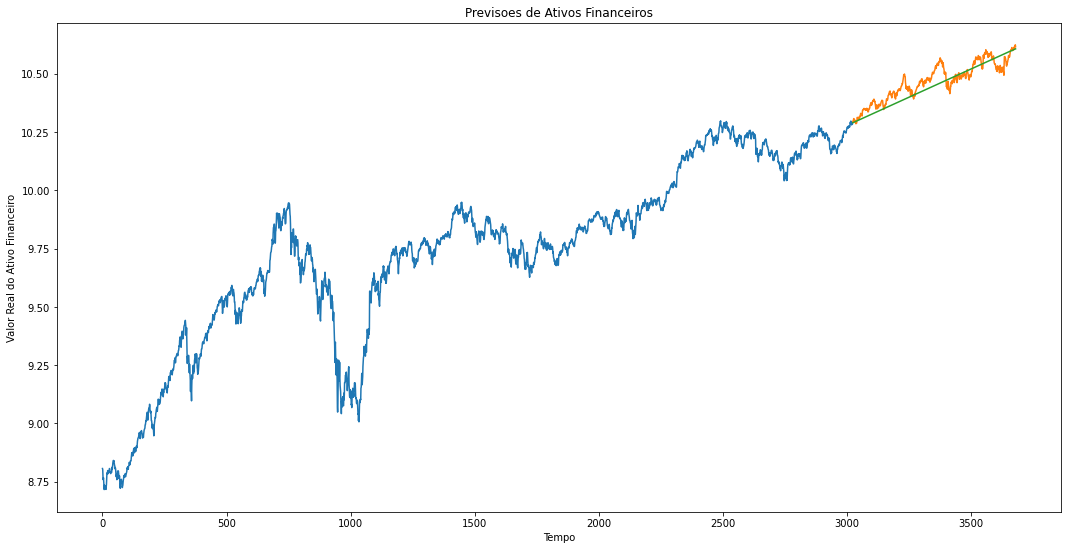

In [52]:
# Plot
plt.figure(figsize = (18, 9))
plt.plot(dados_treino_log, label = 'Dadosde Treino')
plt.plot(dados_teste_log, label = 'Dados de Teste')
plt.plot(previsoes, label = 'Previsoes')
plt.title('Previsoes de Ativos Financeiros')
plt.xlabel('Tempo')
plt.ylabel('Valor Real do Ativo Financeiro')

Calculamos o erro do modelo.

In [54]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(dados_teste_log, previsoes))
print('RMSE : ', rms)

RMSE :  0.04073409521630418


## Análise Textual

Leia o manual em pdf no Capítulo 12.

In [55]:
# Função para obter subjetividade
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [56]:
# Função para obter polaridade
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [58]:
# Adicionando ao dataframe
df_texto['Subjectivity'] = df_texto['News'].apply(getSubjectivity)
df_texto['Polarity'] = df_texto['News'].apply(getPolarity)

In [59]:
# Visualiza
df_texto.head()

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485


In [60]:
# Criando um analisador de sentimento
analisador = SentimentIntensityAnalyzer()

In [61]:
%%time
# Analise de sentimentos
df_texto['Compound'] = [analisador.polarity_scores(v)['compound'] for v in df_texto['News']]
df_texto['Negative'] = [analisador.polarity_scores(v)['neg'] for v in df_texto['News']]
df_texto['Neutral'] = [analisador.polarity_scores(v)['neu'] for v in df_texto['News']]
df_texto['Positive'] = [analisador.polarity_scores(v)['pos'] for v in df_texto['News']]

Wall time: 54min 46s


In [63]:
# Visualiza
df_texto.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131


## Merge dos Dados Numéricos e de Texto

In [64]:
# Visualiza
df_numerico.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [65]:
# Visualiza
df_texto.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131


In [66]:
# Vamos concatenar os dataframe pela coluna de data
df_merge = pd.merge(df_numerico, df_texto, how = 'inner', on = 'Date')

In [67]:
# Visualiza
df_merge.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0,ICAI compliments minister Partnering for futur...,0.398414,0.066700,-0.9926,0.152,0.749,0.098
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0,Arab Gaze Uniform Laws Tsunami Relief Double S...,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0,Quake Rumours Mishap reunites yr boy with f...,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0,Doon School preparing to admit girls Market M...,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0,Faultline Repair No Parade Please NRI Spirit ...,0.450775,0.061027,-0.9958,0.139,0.772,0.088


## Criando os Datasets Para Treino dos Modelos

In [68]:
# Dataframe com as variáveis que serão usadas para treinar os modelos
df_merge1 = df_merge[['Close', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]

In [69]:
# Visualiza
df_merge1.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,6679.200195,0.398414,0.066700,-0.9926,0.152,0.749,0.098
1,6651.009766,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,6458.839844,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,6367.390137,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,6420.459961,0.450775,0.061027,-0.9958,0.139,0.772,0.088


> Os dataframes abaixo serão usados para o modelo de série temporal.

In [70]:
# Colocamos a variável que é a série temporal em outro dataframe
df_time_series = df_merge1['Close']

In [71]:
# Variáveis exógenas
exog_data = df_merge1[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
exog_data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9926,0.152,0.749,0.098
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,0.450775,0.061027,-0.9958,0.139,0.772,0.088
...,...,...,...,...,...,...
3650,0.367645,0.051117,-0.9998,0.138,0.780,0.081
3651,0.384087,0.049062,-0.9999,0.163,0.750,0.087
3652,0.404191,0.051030,-0.9999,0.160,0.749,0.091
3653,0.397646,0.065572,-0.9998,0.121,0.812,0.068


In [72]:
# Variáveis de treino
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

In [73]:
# Variáveis de teste
final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]

> Os dataframes abaixo serão usados para os modelos supervisionados.

In [75]:
# Prepara X (variáveis de entrada)
X = df_merge1.drop('Close', axis = 1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9926,0.152,0.749,0.098
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,0.450775,0.061027,-0.9958,0.139,0.772,0.088
...,...,...,...,...,...,...
3650,0.367645,0.051117,-0.9998,0.138,0.780,0.081
3651,0.384087,0.049062,-0.9999,0.163,0.750,0.087
3652,0.404191,0.051030,-0.9999,0.160,0.749,0.091
3653,0.397646,0.065572,-0.9998,0.121,0.812,0.068


In [76]:
# Prepara Y (variável de saída)
Y = df_merge1['Close']
Y

0        6679.200195
1        6651.009766
2        6458.839844
3        6367.390137
4        6420.459961
            ...     
3650    40889.230469
3651    40821.300781
3652    41020.609375
3653    41130.171875
3654    40793.808594
Name: Close, Length: 3655, dtype: float64

In [77]:
# Divisão em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Modelo de Previsão de Série Temporal

In [79]:
# Modelo de série temporal
modelo_v1 = SARIMAX(final_train_data, exog = exog_train_data, order = (1, 1, 1), seasonal_order = (0, 0, 0, 0))

In [80]:
# Treinamento do modelo
resultado = modelo_v1.fit()

In [81]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3000
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -20600.552
Date:                Tue, 21 Jun 2022   AIC                          41219.103
Time:                        11:37:12   BIC                          41273.158
Sample:                             0   HQIC                         41238.547
                               - 3000                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Subjectivity    58.0917    116.298      0.500      0.617    -169.849     286.032
Polarity        17.3468    113.692      0.153      0.879    -205.485     240.179
Compound         0.8092     10.816      0.075      0.940     -20.390      22.008
Negative      4239.1773   5998.143      0.707      0.480   -7516.966     1.6e+04
Neutral       4526.8589   6000.009      0.754      0.451   -7232.943    1.63e+04
Positive      4532.7601   6010.057      0.754      0.451   -7246.734    1.63e+04
ar.L1           -0.1774      0.160     -1.112      0.266      -0.490       0.135
ma.L1            0.2619      0.157      1.672      0.094      -0.045       0.569
sigma2        5.426e+04    791.158     68.587      0.000    5.27e+04    5.58e+04
===================================================================================
Ljung-Box (Q):                       39.33   Jarque-Bera (JB):              2733.19
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
# Vamos fazer a previsão dos próximos 10 dias
forecast = resultado.forecast(10, exog = exog_test_data[:10])

In [83]:
# Forecast
forecast

3000    29418.514745
3001    29408.277510
3002    29422.363821
3003    29414.595930
3004    29410.012090
3005    29416.012787
3006    29418.913953
3007    29414.470846
3008    29407.842873
3009    29412.867716
dtype: float64

## Modelagem com Modelos Supervisionados

Vamos padronizar os dados e então treinar os modelos.

In [84]:
x_treino.shape

(2924, 6)

In [85]:
x_treino.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
958,0.408964,0.070653,-0.9996,0.167,0.737,0.097
3195,0.408858,0.067826,-0.9999,0.161,0.724,0.115
2985,0.359336,0.039093,-0.9999,0.137,0.775,0.088
2553,0.406633,0.065121,-0.9992,0.108,0.810,0.082
728,0.352812,0.097611,-0.9856,0.097,0.829,0.073


In [86]:
# Cria o scaler para padronizar os dados
scaler = MinMaxScaler()

In [90]:
# Treinamento do scaler
modelo_scaler = scaler.fit(x_treino)

In [91]:
# Aplica em treino
x_treino = modelo_scaler.transform(x_treino)

In [92]:
# Aplica em teste
x_teste = modelo_scaler.transform(x_teste)

In [94]:
x_treino[10]

array([4.86161020e-01, 3.68991653e-01, 5.00025001e-05, 5.51912568e-01,
       4.66911765e-01, 3.91061453e-01])

In [95]:
x_teste[10]

array([4.23317609e-01, 4.44551886e-01, 5.00025001e-05, 4.37158470e-01,
       5.99264706e-01, 3.07262570e-01])

In [96]:
y_treino

958      8937.200195
3195    34443.191406
2985    28999.560547
2553    26813.419922
728     19966.000000
            ...     
835     17230.179688
3264    34450.769531
1653    16361.150391
2607    27931.640625
2732    23088.929688
Name: Close, Length: 2924, dtype: float64

In [97]:
y_teste

1728    16154.620117
2576    28171.689453
999      8779.169922
3316    35574.550781
3146    33213.128906
            ...     
2039    19169.830078
3046    31190.560547
217      8686.650391
670     15603.799805
1232    17554.300781
Name: Close, Length: 731, dtype: float64

## Modelo RandomForestRegressor

In [98]:
# Cria o modelo 
modelo_v2 = RandomForestRegressor()

In [99]:
# Treinamento
modelo_v2.fit(x_treino, y_treino)

RandomForestRegressor()

In [100]:
# Previsões
pred_v2 = modelo_v2.predict(x_teste)

In [102]:
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(pred_v2, y_teste)))

Root Mean Squared Error:  6147.761852989772


## Modelo LGBMRegressor

In [103]:
# Cria o modelo
modelo_v3 = lightgbm.LGBMRegressor()

In [104]:
# Treinamento
modelo_v3.fit(x_treino, y_treino)

LGBMRegressor()

In [105]:
# Previsões
pred_v3 = modelo_v3.predict(x_teste)

In [106]:
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(pred_v3, y_teste)))

Root Mean Squared Error:  6052.087709037161


## Modelo XGBRegressor

In [107]:
# Cria o modelo
modelo_v4 = xgboost.XGBRegressor()

In [108]:
# Treinamento
modelo_v4.fit(x_treino, y_treino)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [110]:
# Previsões
pred_v4 = modelo_v4.predict(x_teste)

In [111]:
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(pred_v4, y_teste)))

Root Mean Squared Error:  6427.608147234259


## Conclusão

Construímos 4 versões do modelo preditivo usando diferentes abordagens. Todos os modelos tem espaço para melhorias, seja no pré-processamento de dados ou na otimização de hiperparâmetros.

Um ponto de observação sobre este projeto é que para usá-lo em produção seria necessário um Engenheiro de Dados para construir todo o pipeline de dados até alimentar o modelo treinado.

Exemplo:

- Para o modelo SARIMAX imagine que tenhamos dados até 30 de Junho e queremos prever o valor do ativo financeiro em 10 de Julho. Treinamos o modelo com dados históricos e seria necessário ter o noticiário econômico de 1 a 9 de Julho e realizar a análise de sentimento, para então usar como variáveis exógenas e prever o próximo item da série.

- Para os modelos tradicionais podemos usar dados históricos de análise de sentimento e prever o valor do ativo financeiro independente da data.

Ambas as opções são quase previsão em tempo real e vão requerer um bom trabalho de Engenharia de Dados para construir o pipeline (sequência ou fluxo) dos dados. Nada impede que usemos dados históricos de análise de sentimento em ambos os casos.